# Exploratory Data Analysis using YouTube Video Data
**Exploring the niche market of LEGO / LEGO reselling YouTube channels**

# Aims and Objectives

This project is being used as a means to explore the following:
* Learning about the YouTube API as a means of collecting video data
* Analyzing the data collected:
    * Does the level of interaction on a video (i.e. number of likes and comments) have any correlation to the number of views?
    * Does the length of the video contribute to the number of views?
    * Does the length of the title have any relation to the number of views?
    * Does the number of tags correlate to the number of views? Likewise, what are the most common used tags in this niche market?

# Steps Needed
* Obtain video data via the YouTube API for a select number of channels related to LEGO and/or LEGO reselling
    * Create a new developer key
    * Request data
    * Clean and transform the data into a more usable format
* Pre-process the data
* Enhance / Enrich the data
* Exploratory Data Analysis (EDA)
* Conclusions

# Dataset

**Data Selection**

While there are numerous datasets on sites such as Kaggle dealing with LEGO, most of those datasets are focused on LEGO Sets, parts, and minifigures, and not YouTube video data. As such, I needed to create my own dataset using the [Google YouTube Data API version 3.0](https://developers.google.com/youtube/v3), details of which can be found below.

**Data Limitations**

This dataset is a real-world dataset, suitable for analysis. However, the selection of channels used was at my own discretion, based on my own viewership of LEGO related YouTube channels. As noted in the Conclusions section below, expanding this list to include other channels would likely result in a broader dataset to be used.

**Ethics of Data Source**

According to [Youtube API's guide](https://developers.google.com/youtube/v3/getting-started), the usage of Youtube API is free of charge given that your application send requests within a quota limit. "The YouTube Data API uses a quota to ensure that developers use the service as intended and do not create applications that unfairly reduce service quality or limit access for others. " The default quota allocation for each application is 10,000 units per day, and you could request additional quota by completing a form to YouTube API Services if you reach the quota limit.

Since all data requested from Youtube API is public data (which everyone on the Internet can see on Youtube), there is no particular privacy issues as far as I am concerned. In addition, the data is obtained only for research purposes in this case and not for any commercial interests.


In [1]:
# Google API
from googleapiclient.discovery import build

#
import pandas as pd
import numpy as np
from dateutil import parser
import isodate

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style = 'darkgrid', color_codes = True)

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dusti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dusti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data creation with YouTube API
This step includes many smaller steps:
* Created a project on the [Google Developers Console](https://console.cloud.google.com/)
* Requested an authorization credential key (API key)
* Enabled YouTube API for the project created, so that API requests can be sent to YouTube API services
* Obtained the channel ID's for all channels needed
    * Using [this website](https://commentpicker.com/youtube-channel-id.php), I entered the username of the channel, and was able to obtain the ID for that channel
* Created the necessary functions used for obtaining the channel statistics via the YouTube API.

In [97]:
# API key has been removed for upload - please uncomment and use your own API key if you would like to validate this code
# api_key = ''
channel_ids = ['UCmMkENq1cs4IVR07qSFOduQ', # Ralph's Bricks
               'UC-KKBlQ2elq3Jou-SHvoFQg', # Pop's Block Shop
               'UCDKePhKRijhY1eHrGCMUy6A', # Wolf of Bricks
               'UCDfbNXnHPeIyDZKqhTDJt_g', # LeggoMyJamesO
               'UCs8jLT7cU1fqZop1okQM6Aw', # Just A Brick In The Bucket
               'UC8oR4tEdI9CXrQh5DzCvZNQ', # Unsorted Brick
               'UCyUzapNHXGmJ-Xym8SQf23w', # Hillians Bricks
               'UC7pJz27eX5bkYVbUzvkzbcQ', # DOTU Bricks
               'UCrfdSw43vgfno9eHvsH9hYg', # Build a Brick
               'UCV7NgRY33B4O7Vd1S7HrZBQ', # David West
               'UCllUl71YRCKxRZtV6Jqf9Dg', # JB's Brick Kiln
               'UCSPvxAcyjr3h6kCJEGMi9gw', # Valente Productions
               'UCyf3dQSh58RfT6P4SRmydIQ', # Brick Arena
              ]

# Get credentials and create an API client
youtube = build('youtube', 'v3', developerKey=api_key)

In [4]:
def get_channel_stats(youtube, channel_ids):
    '''
    Gets channel statistics: 
    title, subscriber count, view count, video count, upload playlist
    
    Returns a dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    '''
    
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)


def get_video_ids(youtube, playlist_id):
    
    ''' 
    Gets a list of video ID's of all videos in the given playlist

    Returns a list of video ID's of all videos in the given playlist
    '''

    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids


def get_video_details(youtube, video_ids):
    """
    Gets video statistics of all videos with given IDs
    
    Returns a dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)


def get_comments_in_videos(youtube, video_ids):
    '''
    Gets top level comments as text from videos with given ID's (first 10 comments, due to YouTube quote limit)

    Returns:
    Datafram with video ID's and assosicated top level comment in text
    '''
   
    all_comments = []

    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
                part='snippet,replies',
                videoId=video_id
            )
            response = request.execute()
    
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}
    
            all_comments.append(comments_in_video_info)

        # This error usually occurs when comments are disabled on a video
        except:
            print('Could not get comments for video ' + video_id)

    return pd.DataFrame(all_comments)

**Channel Statistics**

Using the ```get_channel_stats function```, we can obtain the channel statistics for the given list

In [5]:
channel_data = get_channel_stats(youtube, channel_ids)

Printing out the data to look at overall statistics

In [6]:
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,Just A Brick In The Bucket,7570,911929,354,UUs8jLT7cU1fqZop1okQM6Aw
1,DOTU Bricks,918,169302,807,UU7pJz27eX5bkYVbUzvkzbcQ
2,LeggoMyJamesO,2210,360327,232,UUDfbNXnHPeIyDZKqhTDJt_g
3,Unsorted Brick,1040,84005,80,UU8oR4tEdI9CXrQh5DzCvZNQ
4,Build a Brick,339,21435,61,UUrfdSw43vgfno9eHvsH9hYg
5,Brick Arena,5000,556793,222,UUyf3dQSh58RfT6P4SRmydIQ
6,David West,779,57511,97,UUV7NgRY33B4O7Vd1S7HrZBQ
7,WOLF OF BRICKS,7140,881133,372,UUDKePhKRijhY1eHrGCMUy6A
8,Ralph's Bricks,1700,123384,223,UUmMkENq1cs4IVR07qSFOduQ
9,Pop's Block Shop,5660,1061553,601,UU-KKBlQ2elq3Jou-SHvoFQg


Since the count columns in ```channel_data``` is in string format, it needs to be converted to numeric so it can be visualized and manipulated

In [7]:
# Converting count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

Taking a look at the number of subscribers per channel to see how popular the channels are when compared to each other

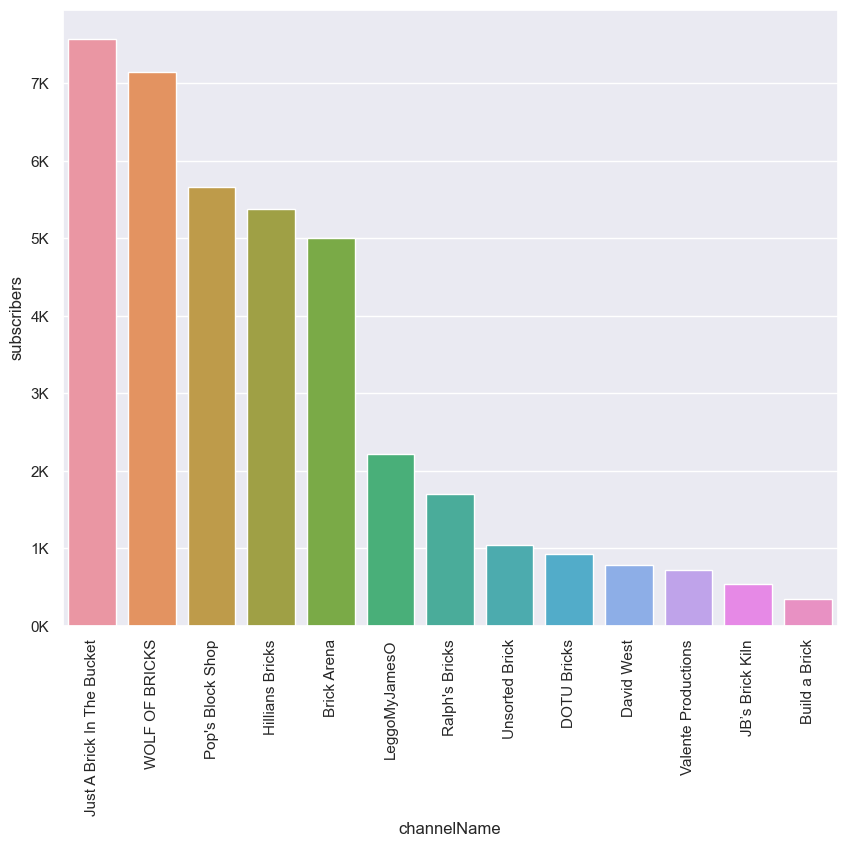

In [8]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

Taking a look at the total number of views per channel. It is interesting to note some of the changes in ranks, most notibly that Just A Brick In The Bucket and WOLF OF BRICKS both have more subscribers than Pop's Block Shop, but Pop's Block Shop has outranked both channels in terms of views.

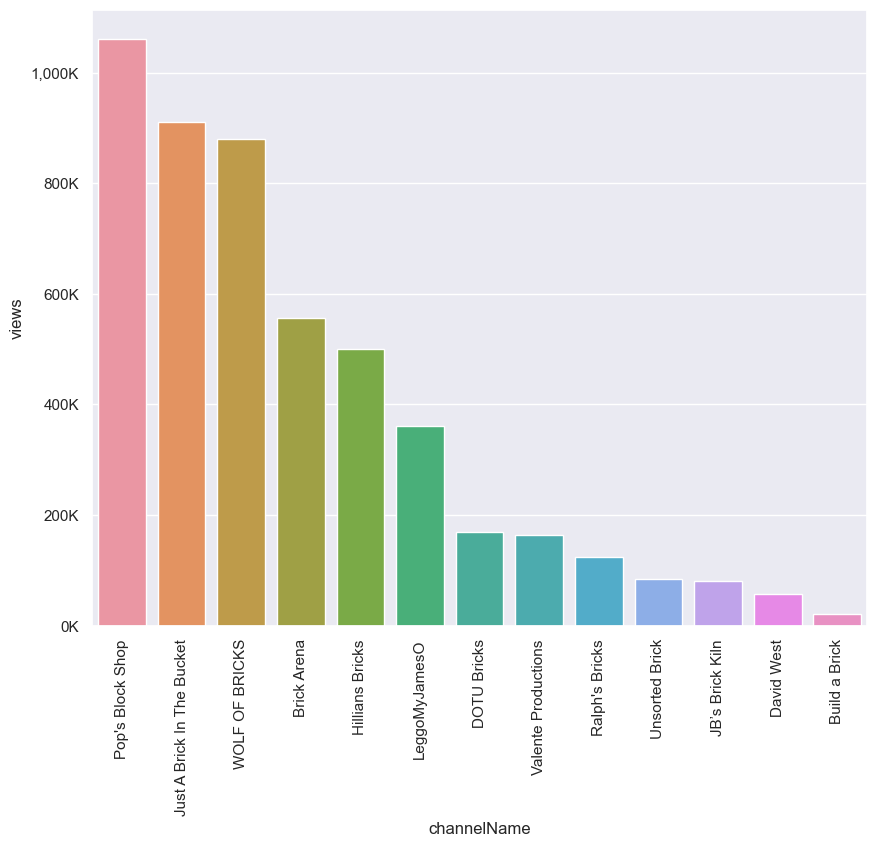

In [9]:
ax = sns.barplot(x='channelName', y='views', data=channel_data.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

**Getting video statistics for all channels in the list**

Next, I need to obtain the video stats for all the channels. In total, there were ___ videos obtained.

In [10]:
# Creating a dataframe with video statistics and comments from all channels

video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    # get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)

    # append video data together and comment data toghether
    video_df = pd.concat([video_df, video_data])
    comments_df = pd.concat([comments_df, comments_data])

Getting video information from channel: Just A Brick In The Bucket
Getting video information from channel: DOTU Bricks
Could not get comments for video ptQRV76K3zQ
Getting video information from channel: LeggoMyJamesO
Could not get comments for video rEFjTCtm9JM
Getting video information from channel: Unsorted Brick
Getting video information from channel: Build a Brick
Could not get comments for video u4O7z7JlZKE
Getting video information from channel: Brick Arena
Getting video information from channel: David West
Could not get comments for video rleblAXQ06w
Getting video information from channel: WOLF OF BRICKS
Could not get comments for video I6_LWwHlC3E
Getting video information from channel: Ralph's Bricks
Getting video information from channel: Pop's Block Shop
Could not get comments for video txB2T22VEAc
Could not get comments for video TCSiEecdBpM
Could not get comments for video aYjVeWNB2_8
Could not get comments for video rwpW304A_UM
Could not get comments for video ZIb2OFQ63c

Taking a look at both ```video_df``` and ```comments_df```

In [11]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,PVTqJgjD3XU,Just A Brick In The Bucket,BrickSide Chat Ep. 13: Taking Control of Your ...,BrickSide Chat Ep. 13: Taking Control of Your ...,"[lego, bricklink, how to, just a brick in the ...",2023-06-23T11:00:31Z,229,7,None,3,PT1H14M20S,hd,false
1,wTjs7PW0Lws,Just A Brick In The Bucket,LIVE SORTING! | Sorting Minifigure Parts and A...,LIVE SORTING! | Sorting Minifigure Parts and A...,"[LEGO, Hogwarts, just a brick in the bucket, b...",2023-06-04T11:00:20Z,685,47,None,0,PT1H21M26S,hd,false
2,rqxYDylzN70,Just A Brick In The Bucket,BrickSide Chat Ep. 12: Using Your Resources As...,BrickSide Chat Ep. 12: Using Your Resources As...,"[lego, bricklink, how to, just a brick in the ...",2023-05-16T03:45:01Z,475,24,None,12,PT1H25M15S,hd,false
3,BNtlQVYMNbg,Just A Brick In The Bucket,LIVE SORTING! | B-Sorting LEGO Minifigure Part...,LIVE SORTING! | B-Sorting LEGO Minifigure Part...,"[LEGO, Hogwarts, just a brick in the bucket, b...",2023-05-07T10:28:37Z,836,33,None,6,PT1H17M36S,hd,false
4,wkqHQjP1Dhw,Just A Brick In The Bucket,Our LEGO Cleaning Process #bricklink #lego,,None,2023-05-01T17:00:34Z,1749,70,None,7,PT36S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,oFEdPnOKdcs,Hillians Bricks,Lego set 75979 - Harry Potter Hedwig Review & ...,This brand new set was launched in the UK on 1...,"[Lego, How To Build, Guide, Building, Instruct...",2020-06-02T21:57:46Z,142,4,None,0,PT14M6S,hd,false
575,PPJybh1vKrk,Hillians Bricks,LEGO TRAIN TRACK LAYOUT USING TRIXBRIX ELEMENTS,Check out this video to see how my son and I c...,"[Lego, Train, Trains, Track, Elevated, Higher,...",2020-05-11T09:50:27Z,138,3,None,0,PT4M36S,hd,false
576,xr8i6E8qjTQ,Hillians Bricks,How to build incline lego train track using tr...,In this video we will share how you can effect...,"[Lego, Train, Trains, Track, Elevated, Higher,...",2020-05-03T12:00:34Z,157,1,None,0,PT4M50S,hd,false
577,pMbdODgVQOw,Hillians Bricks,How to Build Elevated Lego Train Tracks - Trix...,Always wondered how to best create an elevated...,"[Lego, Train, Trains, Track, Elevated, Higher,...",2020-05-02T17:34:05Z,120,3,None,0,PT3M42S,hd,false


In [12]:
comments_df

,video_id,comments
0,PVTqJgjD3XU,[I find the podcast quite interesting and have...
1,wTjs7PW0Lws,[]
2,rqxYDylzN70,"[Hi, i am looking for a counting scale to use ..."
3,BNtlQVYMNbg,[I got a question. Why do y’all rub the parts ...
4,wkqHQjP1Dhw,[Wheres a good place to buy these used parts i...
...,...,...
571,oFEdPnOKdcs,[]
572,PPJybh1vKrk,[]
573,xr8i6E8qjTQ,[]
574,pMbdODgVQOw,[]


In [13]:
# Writing video data to CSV file for future references
video_df.to_csv('video_data.csv')
comments_df.to_csv('comments_data.csv')

### Pre-processing

In order to make use of the data for analysis, I needed to perform some pre-processing. This includes reformating some of the column names, and adding some new features that could prove useful for understanding the video statistics and data.

First I needed to check if there were any empty values, and if so, which field they occur in.

In [14]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount          True
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

Next, I checked if there were any strangly formatted dates in the publish date column.

In [15]:
video_df.publishedAt.sort_values().value_counts()

publishedAt
2023-05-25T00:30:14Z    2
2023-04-19T23:30:03Z    2
2023-04-24T23:30:15Z    2
2023-04-24T23:30:14Z    2
2023-06-01T18:30:13Z    2
                       ..
2021-07-05T21:37:55Z    1
2021-07-06T19:00:04Z    1
2021-07-06T21:12:27Z    1
2021-07-07T13:24:44Z    1
2023-07-02T17:00:16Z    1
Name: count, Length: 3771, dtype: int64

Then I needed to check the data types in the columns, to see if any needed to be changed to new data types.

In [16]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

As you can see, some of the column data types are not in a numeric format, and so I needed to change those. The columns that need to be in a numeric format are ```'viewCount'```, ```'likeCount'```, ```'favouriteCount'```, and ```'commentCount'```

In [17]:
cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

Just to double check that those columns were indeed changed to a numeric format

In [18]:
video_df.dtypes

video_id           object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
viewCount         float64
likeCount         float64
favouriteCount    float64
commentCount      float64
duration           object
definition         object
caption            object
dtype: object

## Data Enrichment

There were multipe enrichments I wanted to perform to the data, in order to ease and enhance later analysis:

* Creating a new column for ```'publishDay'```, showing the day of the week the video was published
* Converting the video duration to seconds instead of the current default string format
* Calculating the number of tags for each video
* Calculating the number of comments and likes per 1000 view ratio
* Calculating the title length

In [19]:
# Creating a new column for 'publishDay', showing the day of the week the video was published
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(str(x)))
video_df['publishDay'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [20]:
# Converting the video duration to seconds instead of the current default string format
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [21]:
# Calculating the number of tags for each video
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [22]:
# Calculating the number of comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount'] / video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount'] / video_df['viewCount'] * 1000

In [23]:
# Calculating the title length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

Checking the dataset to see all the new changes

In [24]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishDay,durationSecs,tagCount,likeRatio,commentRatio,titleLength
0,PVTqJgjD3XU,Just A Brick In The Bucket,BrickSide Chat Ep. 13: Taking Control of Your ...,BrickSide Chat Ep. 13: Taking Control of Your ...,"[lego, bricklink, how to, just a brick in the ...",2023-06-23 11:00:31+00:00,229.0,7.0,NaN,3.0,PT1H14M20S,hd,false,Friday,0 days 01:14:20,8,30.567686,13.100437,77
1,wTjs7PW0Lws,Just A Brick In The Bucket,LIVE SORTING! | Sorting Minifigure Parts and A...,LIVE SORTING! | Sorting Minifigure Parts and A...,"[LEGO, Hogwarts, just a brick in the bucket, b...",2023-06-04 11:00:20+00:00,685.0,47.0,NaN,0.0,PT1H21M26S,hd,false,Sunday,0 days 01:21:26,24,68.613139,0.000000,63
2,rqxYDylzN70,Just A Brick In The Bucket,BrickSide Chat Ep. 12: Using Your Resources As...,BrickSide Chat Ep. 12: Using Your Resources As...,"[lego, bricklink, how to, just a brick in the ...",2023-05-16 03:45:01+00:00,475.0,24.0,NaN,12.0,PT1H25M15S,hd,false,Tuesday,0 days 01:25:15,8,50.526316,25.263158,69
3,BNtlQVYMNbg,Just A Brick In The Bucket,LIVE SORTING! | B-Sorting LEGO Minifigure Part...,LIVE SORTING! | B-Sorting LEGO Minifigure Part...,"[LEGO, Hogwarts, just a brick in the bucket, b...",2023-05-07 10:28:37+00:00,836.0,33.0,NaN,6.0,PT1H17M36S,hd,false,Sunday,0 days 01:17:36,24,39.473684,7.177033,63
4,wkqHQjP1Dhw,Just A Brick In The Bucket,Our LEGO Cleaning Process #bricklink #lego,,None,2023-05-01 17:00:34+00:00,1749.0,70.0,NaN,7.0,PT36S,hd,false,Monday,0 days 00:00:36,0,40.022870,4.002287,42


# Exploratory Analysis

## View distribution per channel

Now that the statistics for every channel are processed, I wanted to see how the views were distributed per channel. I'm using a violin plot to visualize this. The shorter the line and wider and the curve, the less overall views, but the more consistent across those videos. The taller the line, the larger the variance in the channel views.

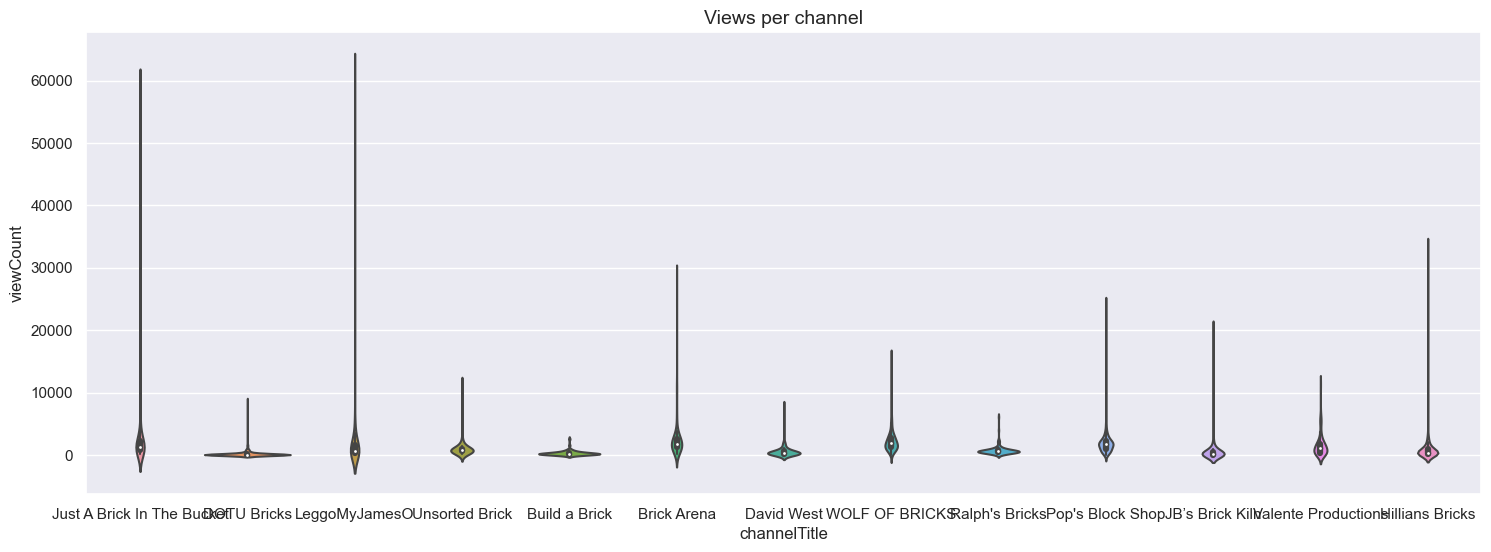

In [25]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(x = video_df['channelTitle'], y = video_df['viewCount'])
plt.title('Views per channel', fontsize = 14)
plt.show()

### Does the number of likes and comments a video has correlate to the number of views of that video. i.e., Do comments and likes matter in order to get more views?

I wanted to check if the number of comments and likes directly correlated to the number of views a video would get. Checking the scatter plots directly below, its easy to see that there is a strong correlation between number of comments and likes and the number of views a video gets. This is more evident based on the number of likes a video gets. This was to be expected, however; typically speaking, the more people watching the video, the more comments and likes the video will recieve.

<Axes: xlabel='likeCount', ylabel='viewCount'>

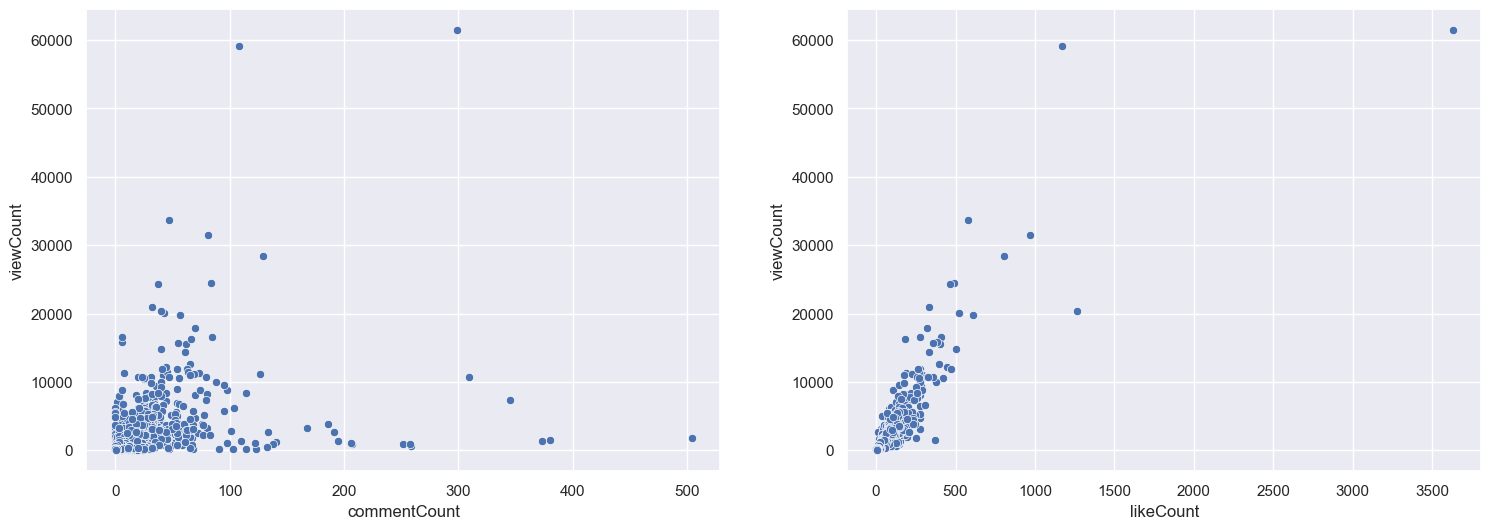

In [26]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

I then made new scatter plots using the ```'commentRatio'``` and ```'likeRatio'``` to see if the correlation changed any. Again, as expected, this correlation lowers significantly. While there is still some correlation between the number of views and the number of comments and likes, this has diminished due to some videos having more views and fewer comments or likes, and some videos having a much smaller view count, but a wider comment and like range.

<Axes: xlabel='likeRatio', ylabel='viewCount'>

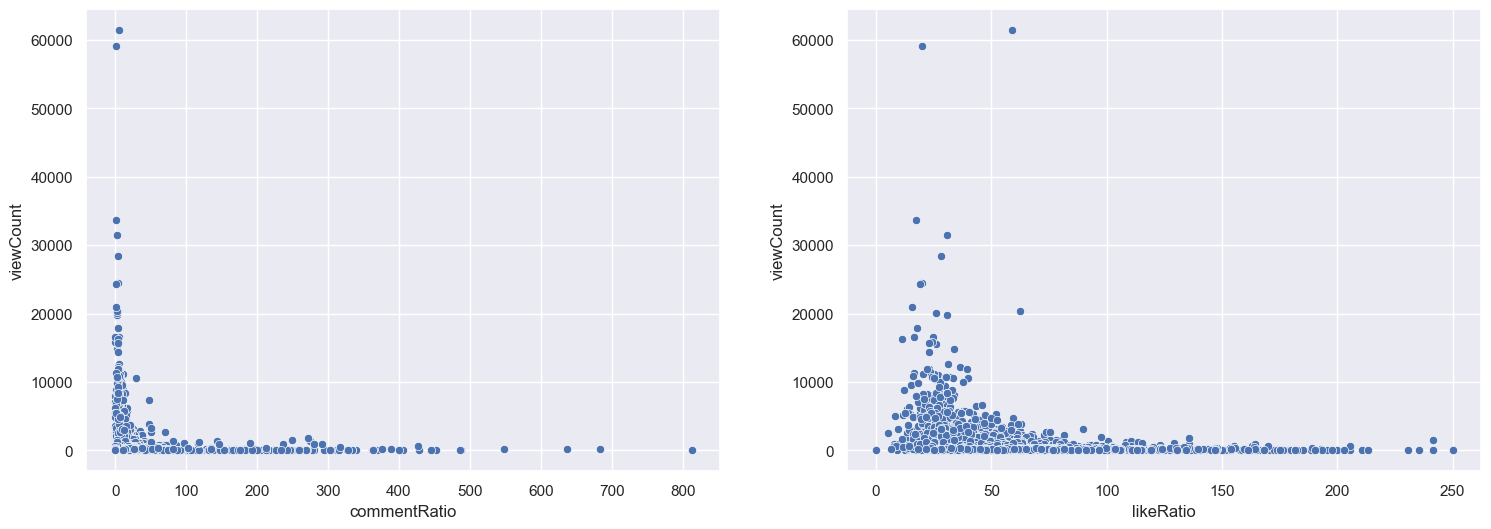

In [27]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

### Does the video length matter in terms of views, likes, and comments?

Firstly, I wanted to see the distribution of video time lengths, limiting the duration to 10,000 seconds (those videos are likely livestreams)

<Axes: xlabel='durationSecs', ylabel='Count'>

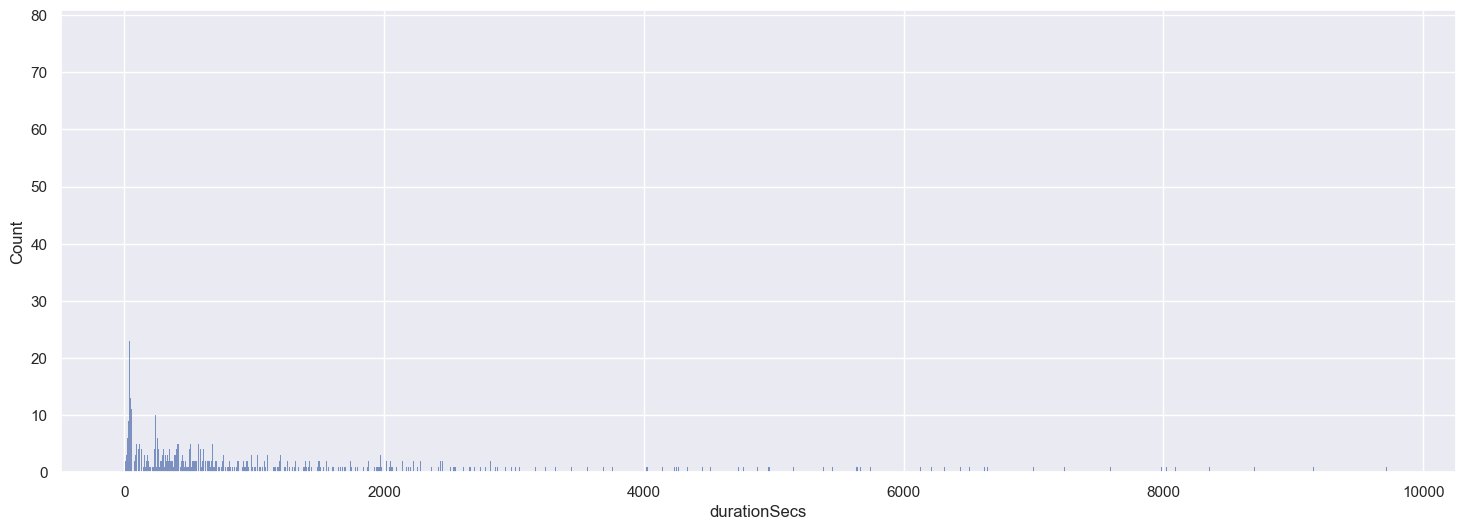

In [46]:
sns.histplot(data = video_df[video_df[('durationSecs')].astype('int64') < 10000], x = 'durationSecs', bins=30)

<Axes: xlabel='durationSecs', ylabel='likeCount'>

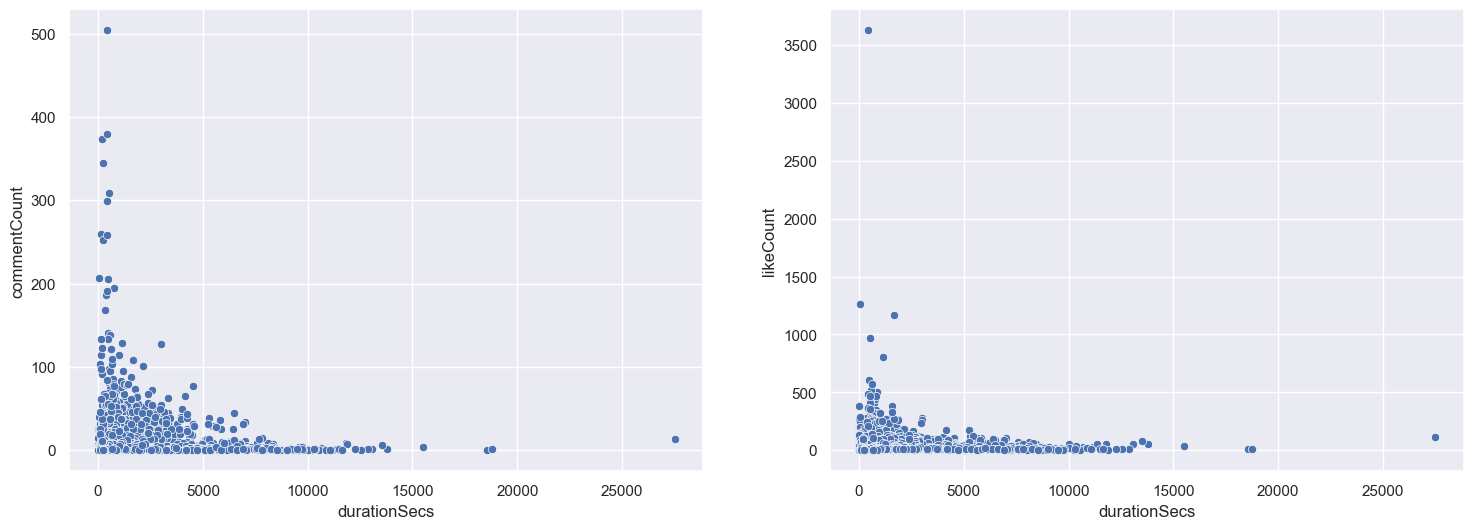

In [37]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = video_df[('durationSecs')].astype('int64'), y = 'commentCount', ax = ax[0])
sns.scatterplot(data = video_df, x = video_df[('durationSecs')].astype('int64'), y = 'likeCount', ax = ax[1])


### Does the title length correlate to the number of views?

As you can see, there really is no corrleation between the length of the video title and the number of views that video gets.

<Axes: xlabel='titleLength', ylabel='viewCount'>

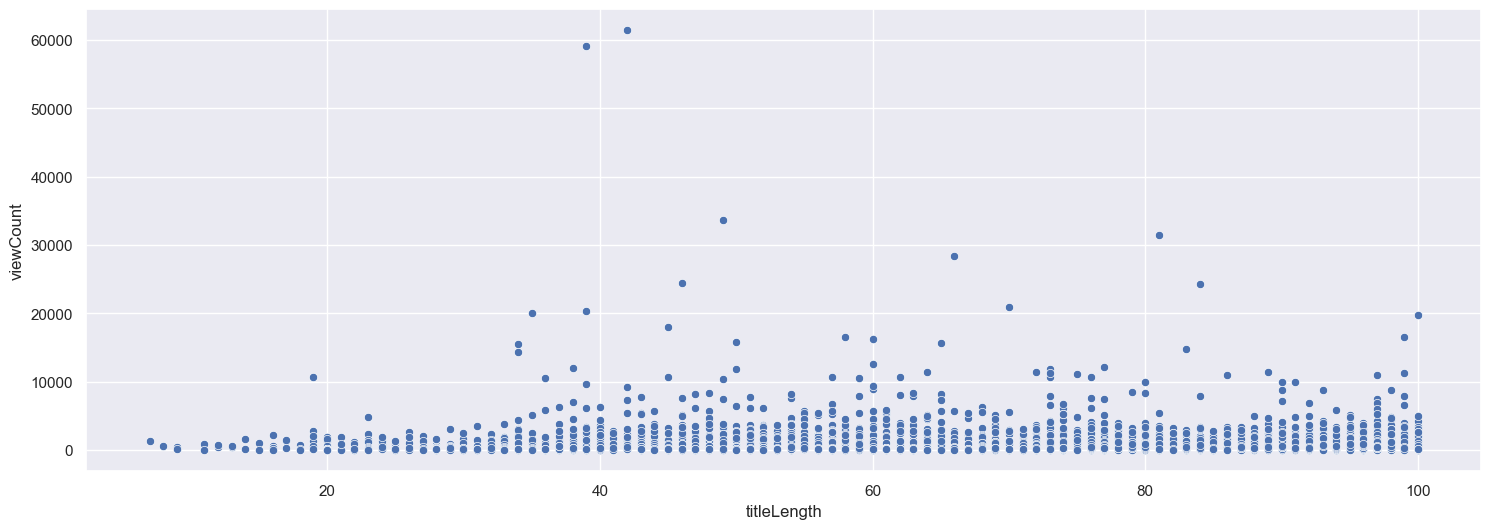

In [30]:
sns.scatterplot(data = video_df, x = 'titleLength', y = 'viewCount')

### Wordcloud for words in the title

As all of these channels are LEGO / Bricklink reselling related in some way, I wanted to see which terms appeared most frequently in the video titles. For this, I created a wordloud for the most common words. I did remove common words such as 'you', 'I', 'the', etc., which would not contribute any meaning

In [31]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

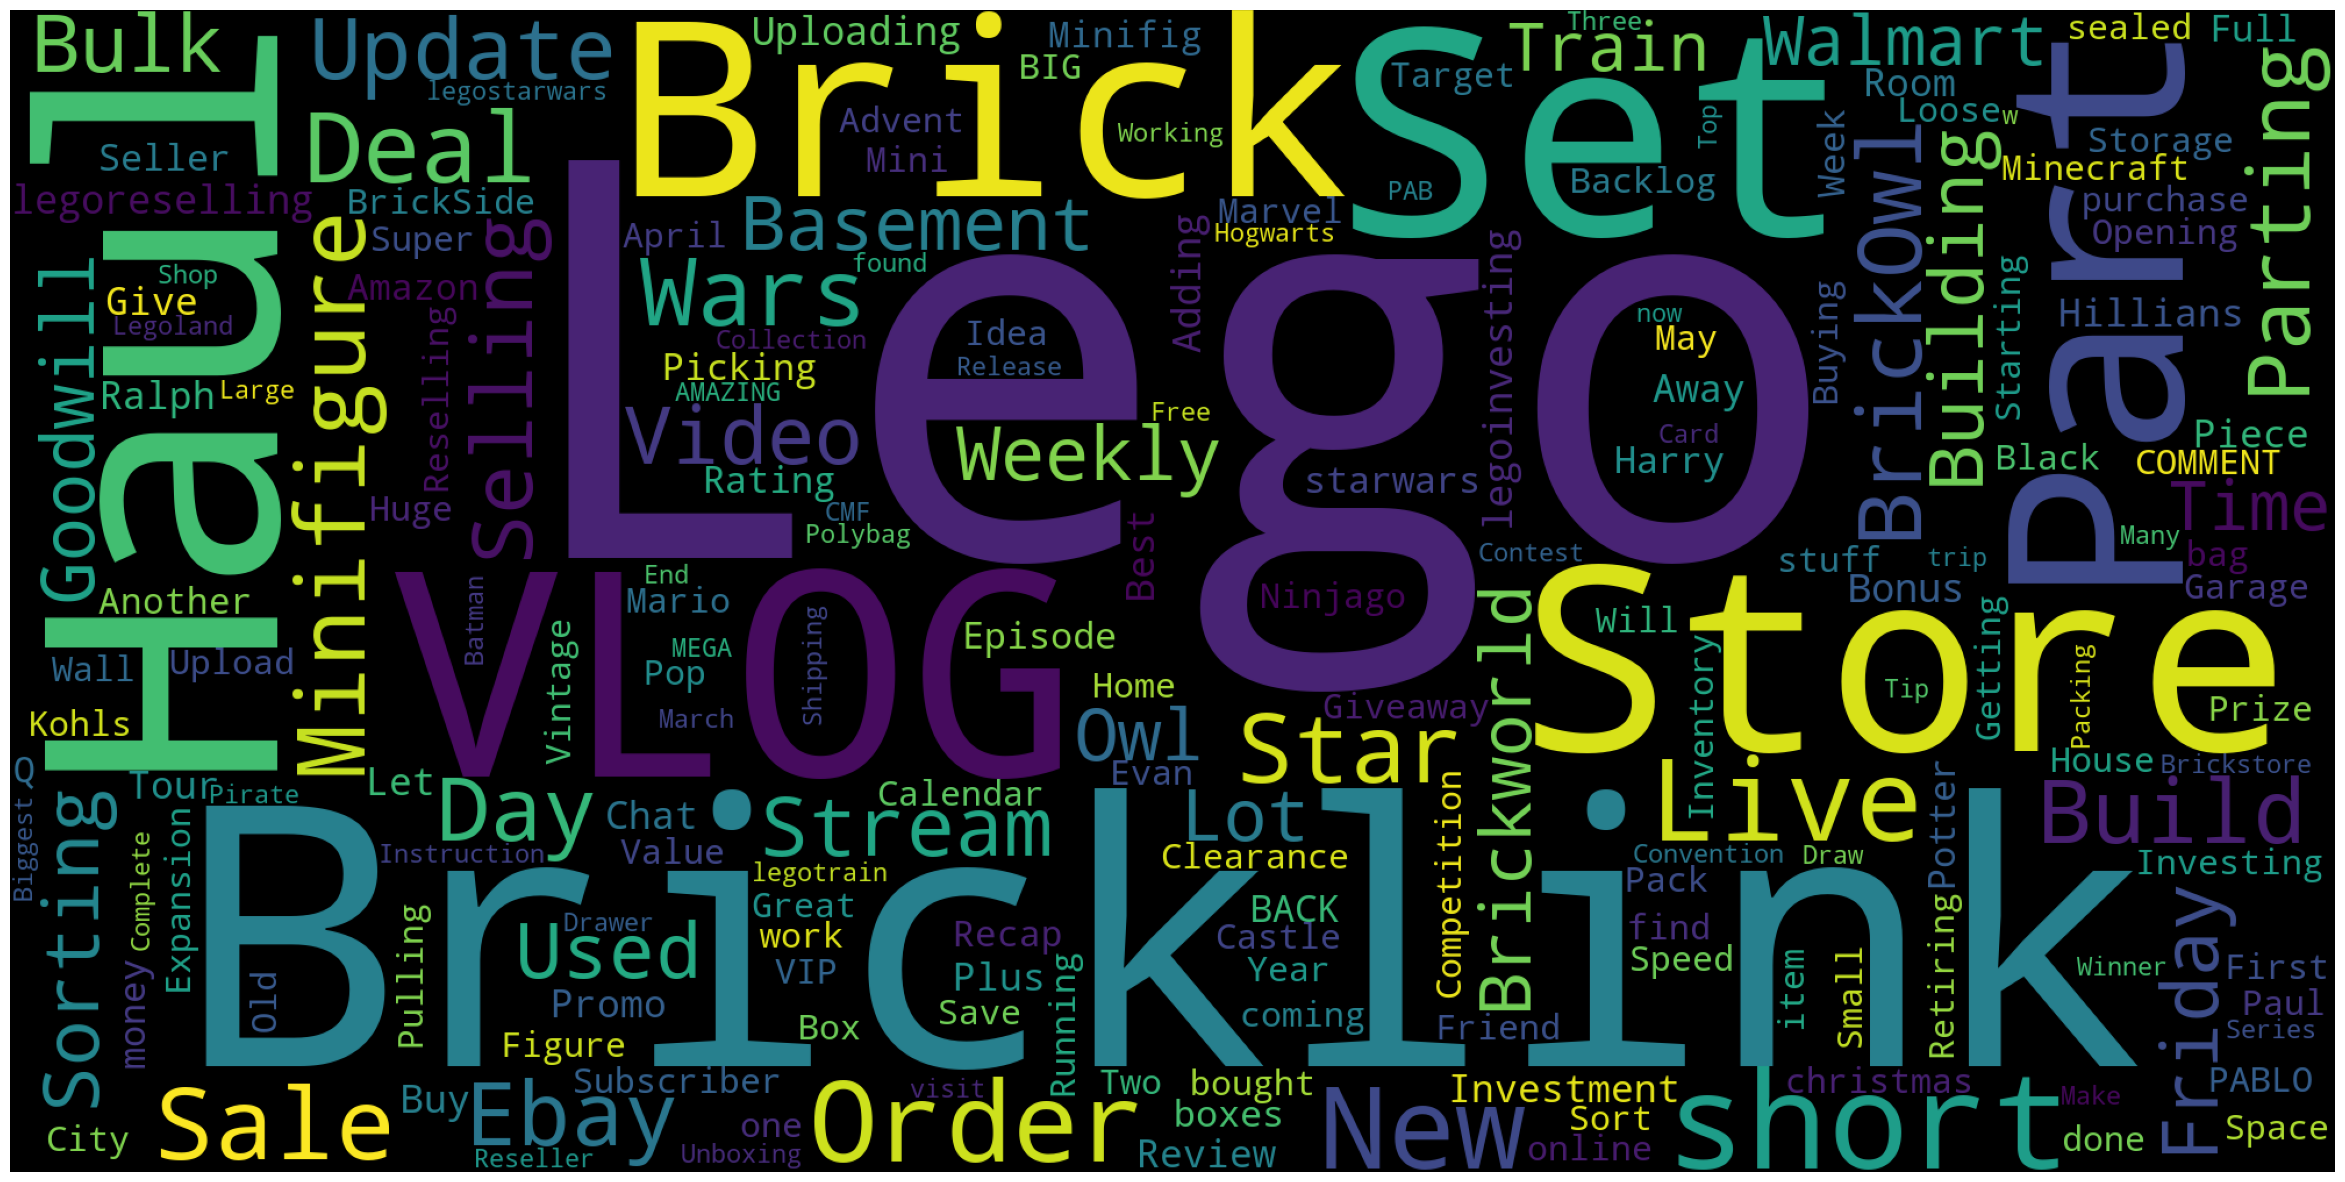

In [32]:
def plot_cloud(wordcloud):
    plt.figure(figsize = (30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state = 1, background_color = 'black', 
                      colormap = 'viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Does the number of tags correlate to the number of views a video might get?

I also wanted to check to see if there was any correlation between the number of tags used vs the number of views a video might get. As noted below, there does not seem to be a direct correlation between the two, with the exception being that possibly too many tags leading to fewer views.

<Axes: xlabel='tagCount', ylabel='viewCount'>

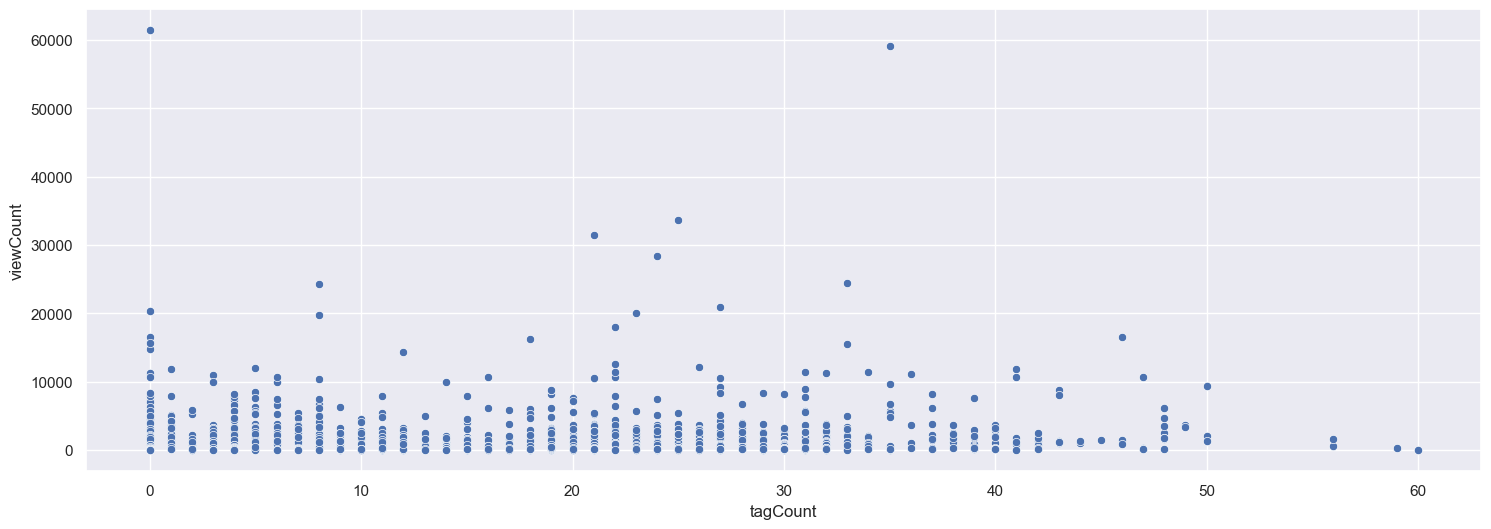

In [33]:
sns.scatterplot(data = video_df, x = 'tagCount', y = 'viewCount')

### Which day of the week are most videos uploaded?

It is interesting to note that the majority of videos are uploaded either on Friday, Sunday, or Monday. Comparing back to the wordcloud for video titles, this is likely due to the high number of 'vlog' videos being uploaded, which means that the creators are vlogging through the week, then uploading that weeks vlog on the weekend.

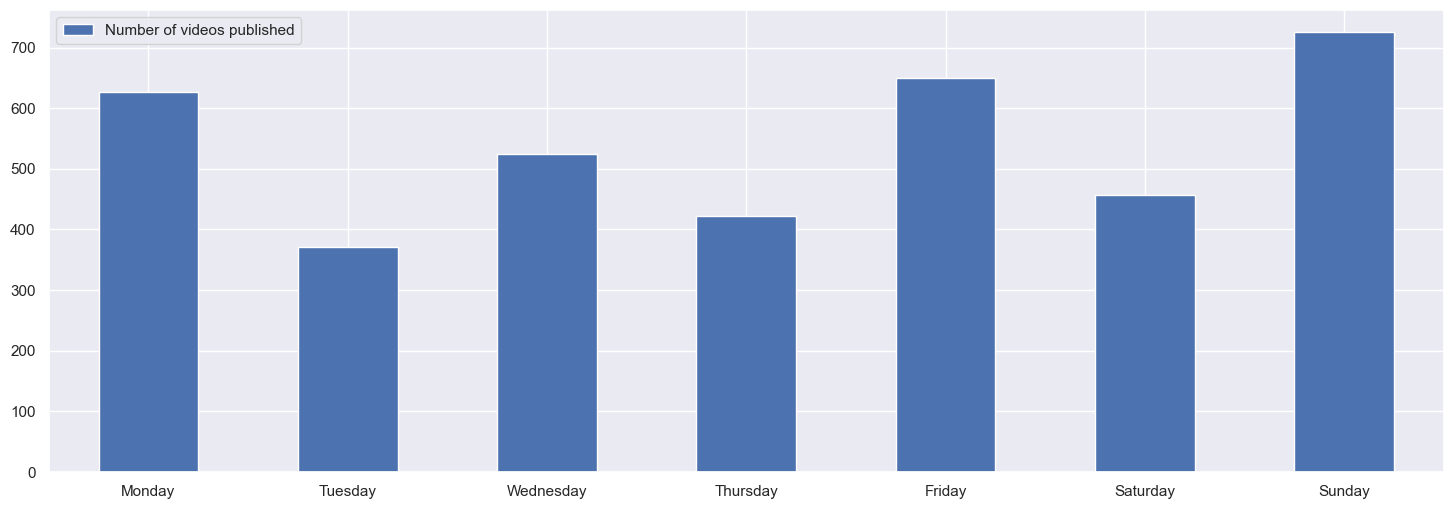

In [92]:
day = video_df['publishDay'].value_counts()
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = pd.DataFrame({'Day of the Week': day_of_week, 'Number of videos published': day}, index = day_of_week)
ax = day_df.plot.bar(rot = 0)

### Wordcloud for comments

Lastly, seeing how interesting the wordcloud for the video titles was, I decided to take a look at one in relation to the video comments.

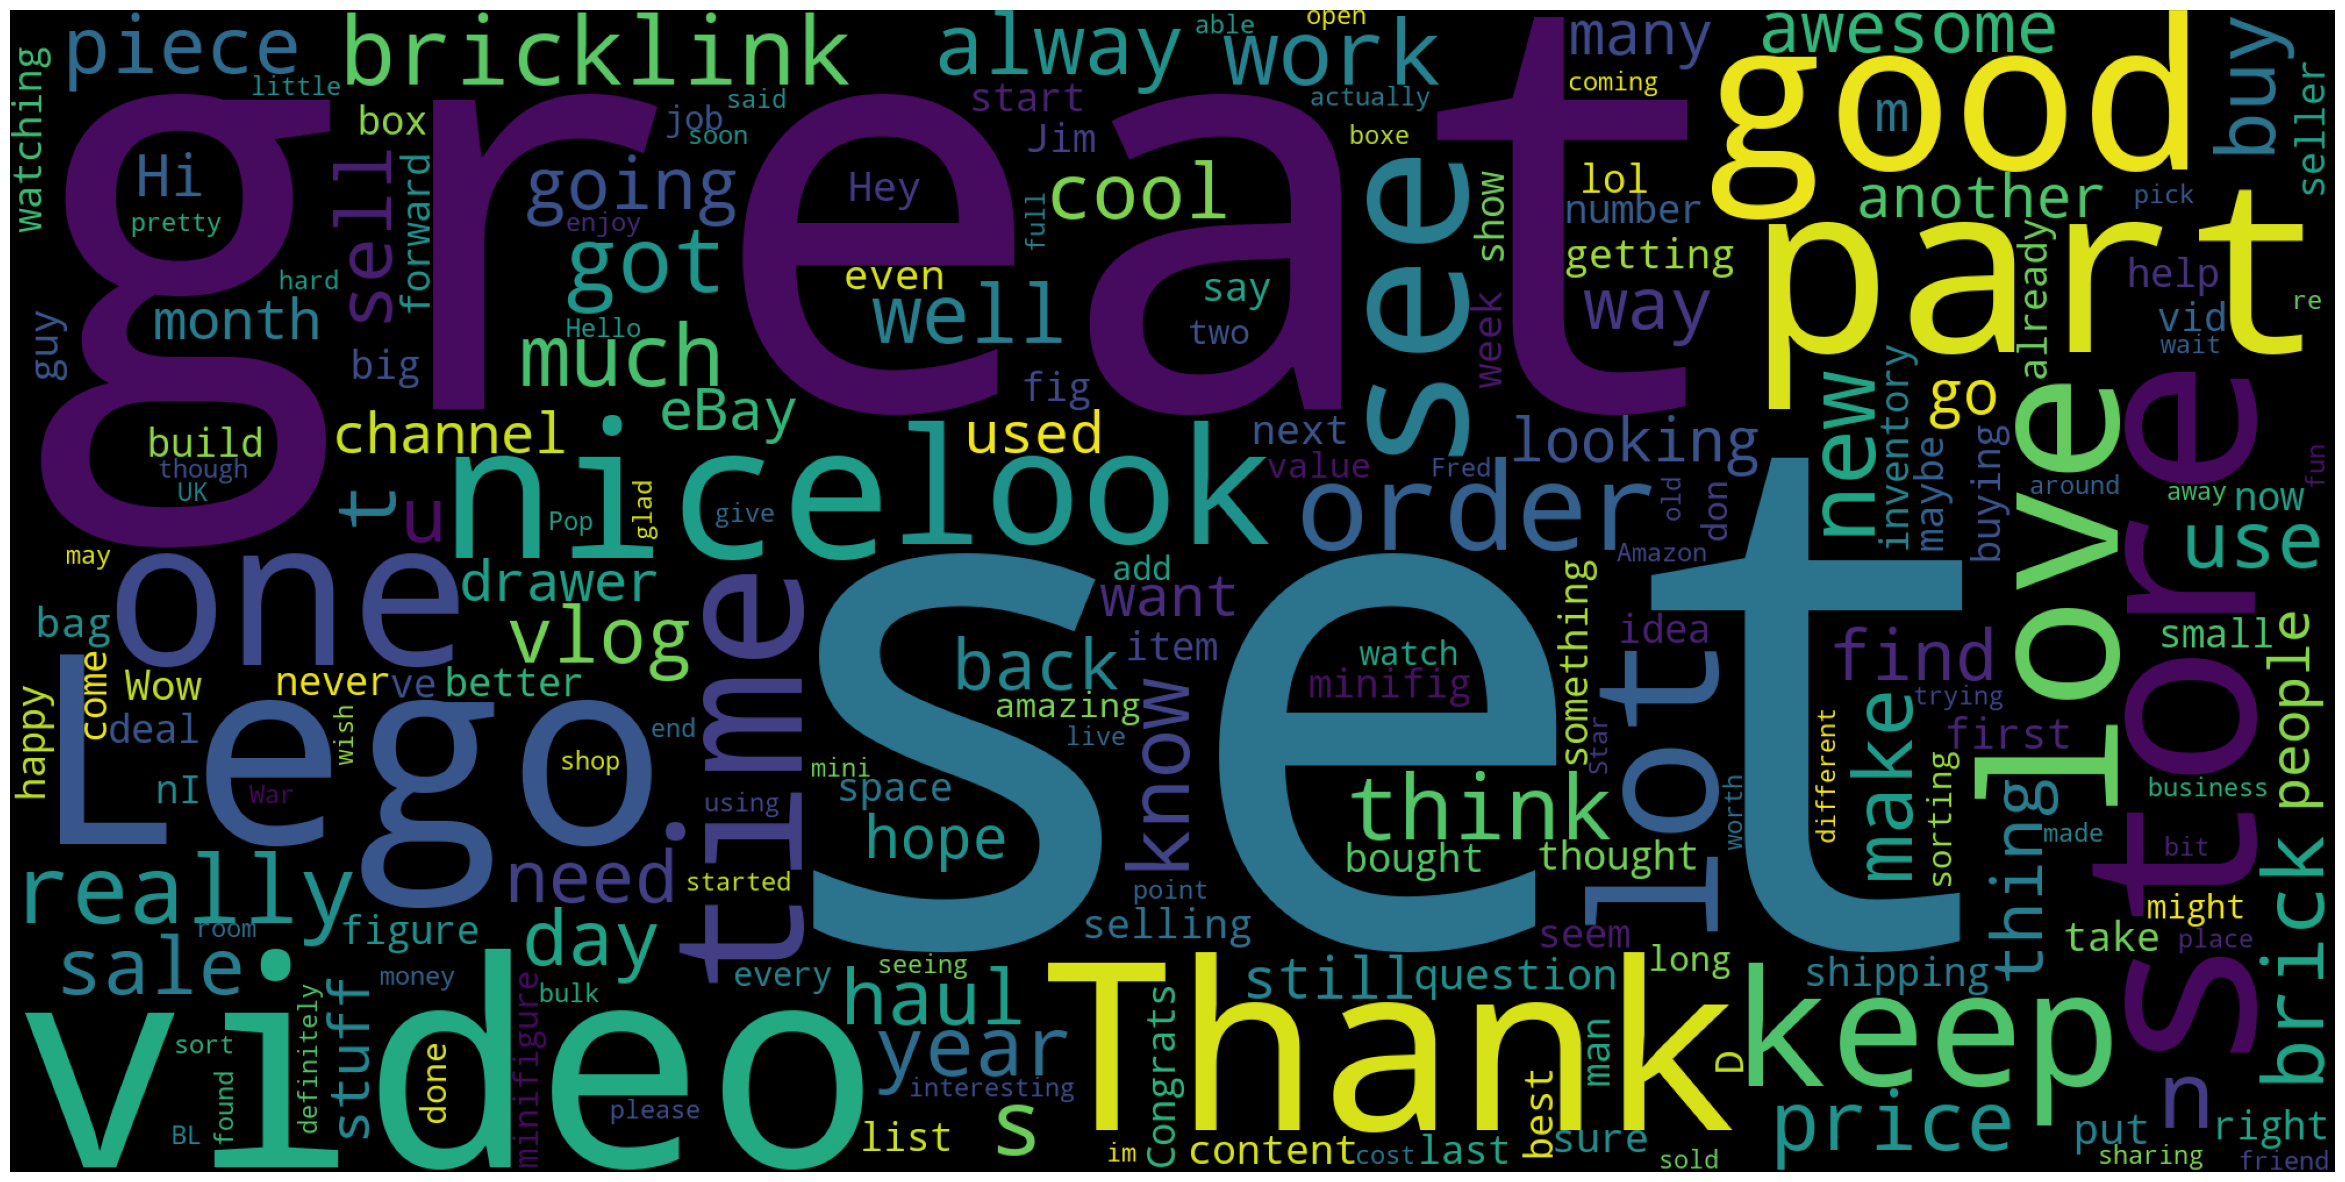

In [53]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

wordcloud = WordCloud(width = 2000, height = 1000, random_state = 1, background_color = 'black', 
                      colormap = 'viridis', collocations = False).generate(all_words_str)
plot_cloud(wordcloud)

# Conclusions and possible future research ideas

In this project, I explored the video data for 13 of the LEGO / Bricklink reselling channels that I personally follow. This analysis revealed quite a few interesting findings, which would be useful for anyone looking to start a YouTube channel in the niche market of LEGO reselling. Some of the more notable findings include:
* The more interaction a video has (i.e. likes and comments), the more that video is likely to be viewed. This can also be seen as the more views a video receives, the higher likelyhood of interaction from viewers.
* The number of tags a video has doesn't seem to play much into the number of views a video might receive. This is likely due to the niche nature of these channels.
* Most videos in this niche market are uploaded on Friday, Sunday, or Monday, likely due to the 'vlog' style videos being uploaded, giving a day-to-day view of a LEGO reseller.
* Comments on the videos are generally positive: 'thank', 'nice', 'love', etc.

**Project limitation**

These findings might not be cumulative across all LEGO / reselling style channels, for a few reasons:
* The dataset is relatively small - Just under 4000 total videos
* Only the first 10 comments for each video have been taken into account, which could be a small subset of comments, and not wholly reflective of the entire interactions.

**Future reasearch ideas**

Building upon the research could be achieved in multiple ways:
* Increasing the number of channels taken into consideration for the dataset
* Expanding the number of comments taken into account, broadening the data for the interaction relation per video, as well as the wordcloud generated
* Looking at the relation between generally postive comments vs generally negative comments, then the releation between both of those against the number of view and/or number of likes a particular video receives